In [1]:
import numpy
import pandas
from sklearn.linear_model import LinearRegression
import seaborn as sns

sns.set_style("whitegrid")

from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt

# The deadly sins of modern data analysis

In order to think rationally on data we **must** understand confounders and colliders. Colliders and confounders are the two most important concepts to get right when doing causality. Confounders are easy to understand - shark attacks and ice creams, etc... But colliders are a bit tougher to grasp at first glance. To make it obvious, let's create an example.


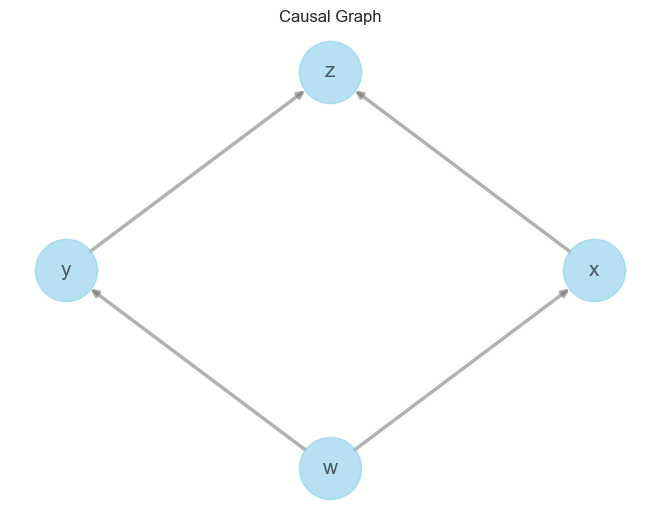

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define nodes and edges
nodes = ["x", "z", "y", "w"]
edges = [("w", "x"), ("w", "y"), ("x", "z"), ("y", "z")]

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Plot the graph
pos = nx.circular_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,
    node_color="skyblue",
    font_size=15,
    width=2.5,
    alpha=0.6,
    edge_color="gray",
)
plt.title("Causal Graph")

plt.show()

### Story time

A company was interested in understanding the relationship between soft skills (X) and technical skills (Y), so they looked into their pool of applicants to understand how these variables were distributed. These applicants were either hired or not hired.


In [3]:
N = 1000
rho_mixing = 0.8
rho_w = 0.1
eta = 0.3
eta_z = 0.1

w = numpy.random.normal(0, 1, N)
x = rho_w * w + eta * numpy.random.normal(0, 1, N)
y = rho_w * w + eta * numpy.random.normal(0, 1, N)
z = (rho_mixing * x + rho_mixing * y + eta_z * numpy.random.normal(0, 1, N)) > 0

df = pandas.DataFrame(
    {"Employee": z, "Education": w, "Soft Skills": x, "Technical Skills": y}
)
df_company = df[df["Employee"]][["Soft Skills", "Technical Skills"]].copy()
df_applicants = df[~df["Employee"]][["Soft Skills", "Technical Skills"]].copy()

PearsonRResult(statistic=-0.3065434175802154, pvalue=2.836585602787358e-12)


Text(0.5, 1.0, 'Technical vs Soft Skills for Company Employees')

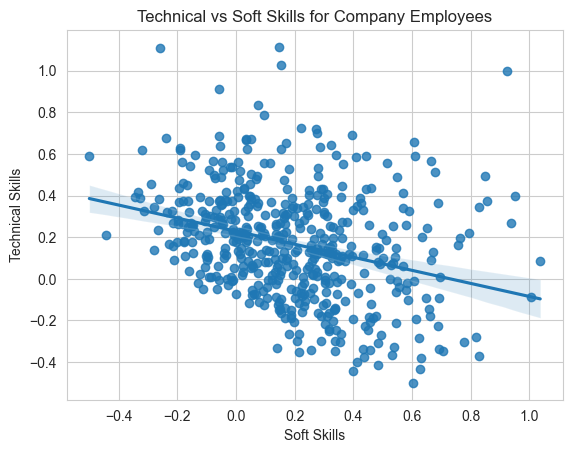

In [6]:
print(pearsonr(df_company["Soft Skills"], df_company["Technical Skills"]))
sns.regplot(
    df_company,
    x="Soft Skills",
    y="Technical Skills",
)

plt.title("Technical vs Soft Skills for Company Employees")

PearsonRResult(statistic=-0.3274297321992007, pvalue=4.925462128293067e-14)


Text(0.5, 1.0, 'Technical vs Soft Skills for applicants who were not hired')

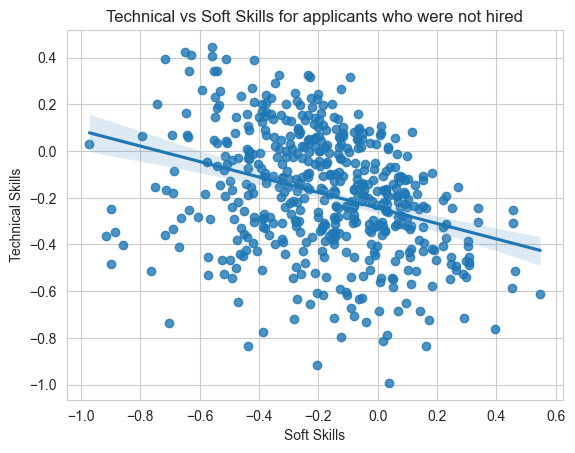

In [7]:
print(pearsonr(df_applicants["Soft Skills"], df_applicants["Technical Skills"]))
sns.regplot(
    df_applicants,
    x="Soft Skills",
    y="Technical Skills",
)
plt.title("Technical vs Soft Skills for applicants who were not hired")

### Conclusion

Us nerds have terrible soft skills. It's in the data!

Or is it?

Now let's look at the entire dataset!


PearsonRResult(statistic=0.11331457970931302, pvalue=0.00033015856310807915)


Text(0.5, 1.0, 'Technical vs Soft Skills for everyone')

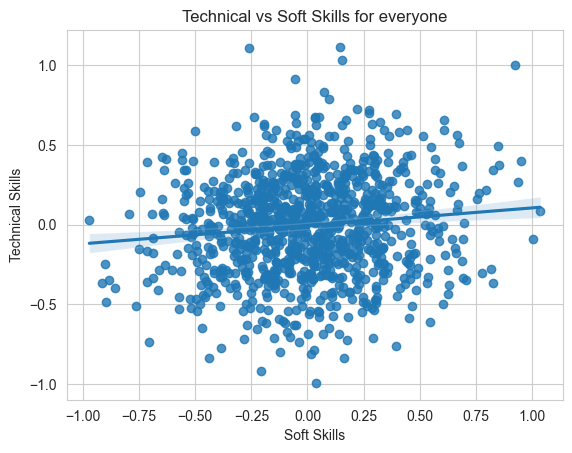

In [8]:
print(pearsonr(df["Soft Skills"], df["Technical Skills"]))
sns.regplot(
    df,
    x="Soft Skills",
    y="Technical Skills",
)
plt.title("Technical vs Soft Skills for everyone")

PearsonRResult(statistic=0.11331457970931302, pvalue=0.00033015856310807915)


Text(0.5, 1.0, 'Technical vs Soft Skills for everyone')

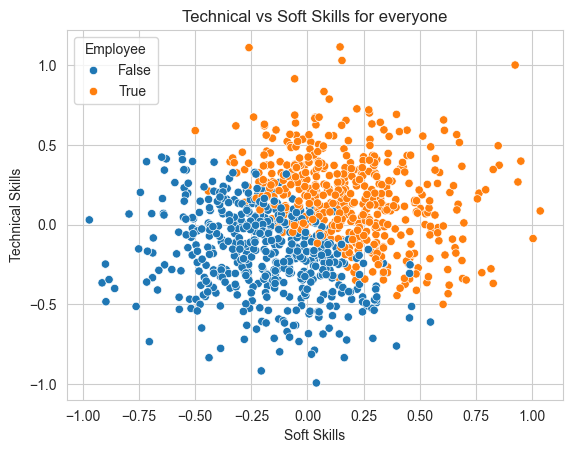

In [10]:
print(pearsonr(df["Soft Skills"], df["Technical Skills"]))
sns.scatterplot(
    df,
    x="Soft Skills",
    y="Technical Skills",
    hue="Employee",
)
plt.title("Technical vs Soft Skills for everyone")
### Conclusion

> ## 1st deadly sin of ~~causal inference~~ 21st century data-driven humans:
>
> **Controlling for colliders will create spurious relationships!**
>
> Other examples:
>
> - Smoking, Fitness, and Lung Disease: Smoking causes lung disease and reduces fitness. Conditioning on fitness can falsely suggest non-smokers have higher lung disease risk.
> - Talent, Training, and Success: Talent leads to success and invites more training. Controlling for training might suggest talented individuals are less successful.
> - Income, Education, and Job Satisfaction: High income can lead to more education but lower job satisfaction. Adjusting for education may incorrectly link income to dissatisfaction.
> - Age, Metabolism, and Weight: Age can slow metabolism and increase weight. Conditioning on metabolism might wrongly show age as protective against weight gain.
> - Stress, Coffee Consumption, and Insomnia: Stress can lead to insomnia and increase coffee drinking. Controlling for coffee can mistakenly associate less stress with insomnia.


#### So there's a positive causal relatinoship between Soft Skills and Technical Skills?

Not there yet! Let's look at the full data?


In [11]:
df.head(5)

,Employee,Education,Soft Skills,Technical Skills
0,False,-1.139924,-0.426664,-0.152055
1,False,-0.177767,-0.232070,0.036649
2,True,1.048675,-0.260467,1.109545
3,True,0.434134,0.129594,0.126856
4,False,-0.781743,-0.491235,-0.237595


Could it be that **education** is **confounding** soft skills and technical skills?


In [15]:
from magpy.oracles.oracles import BaseOracle, linear

In [19]:
oracle = BaseOracle(data=df, learner=linear)

print("Independent: ", oracle("Soft Skills", "Technical Skills", ["Education"]))
print("p-value: ", oracle._run("Soft Skills", "Technical Skills", ["Education"]))

Independent:  True
p-value:  0.7817015087205668


A **high p-value** means that we can reject the hypothesis that they are **causally related** in the presence of Education.


> ## 2nd deadly sin of ~~causal inference~~ 21st century data-driven humans:
>
> **Not controlling for confounders will create spurious relationships!**
>
> Other examples:
>
> - Ice Cream Sales and Drowning: Both rise in summer. Without controlling for season (a confounder), one might falsely think ice cream sales cause drownings.
> - Coffee and Lung Cancer: Heavy coffee drinkers might also smoke. Not adjusting for smoking (a confounder) can misleadingly link coffee to cancer.
> - Gym Membership and Health: People with health issues might get gym memberships. Ignoring health status (a confounder) could falsely suggest gyms worsen health.
> - Internet Use and Academic Performance: Students struggling academically might spend more time online for research. Not controlling for academic difficulty (a confounder) might wrongly link increased internet use to poorer grades.
> - Shoe Size and Reading Ability: Older kids have larger shoe sizes and read better. Failing to adjust for age (a confounder) might misleadingly suggest shoe size predicts reading skills.


### What not to do

What if we just go ahead and fire up old ML on the dataset, predicting the target from the features we have available?


In [20]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV
import shap

/Users/andre/magpy/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
model = GradientBoostingRegressor()
model = LassoCV()


features = ["Education", "Employee", "Technical Skills"]
target = "Soft Skills"
X = df[features]
y = df[target]
model.fit(X, y)

try:
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, plot_type="bar")
except:
    for feature, coef in zip(features, model.coef_):
        print(f"Feature: {feature} \nCoefficient: {coef} \n")

Feature: Education 
Coefficient: 0.07772253824371651 

Feature: Employee 
Coefficient: 0.45091819384371284 

Feature: Technical Skills 
Coefficient: -0.3662477843937994 



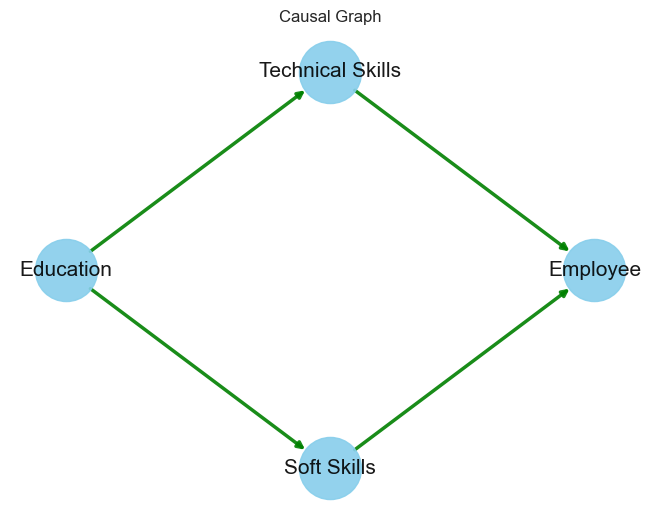

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define nodes and edges
nodes = [
    "Employee",
    "Technical Skills",
    "Education",
    "Soft Skills",
]
edges = [
    ("Technical Skills", "Employee"),
    ("Soft Skills", "Employee"),
    ("Education", "Technical Skills"),
    ("Education", "Soft Skills"),
]

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Plot the graph
pos = nx.circular_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,
    node_color="skyblue",
    font_size=15,
    width=2.5,
    alpha=0.9,
    edge_color="green",
)
plt.title("Causal Graph")

plt.show()

## Conclusion

Causality is simple, you just need to...:

- Include all confounders in your adjustment set
- Remove all colliders from the adjustment set

... but how do I discover them?

## Homework:

Think of an algorithm that will iteratively identify possible confounders and colliders in the data, given all variables.
